In [134]:
print("all ok")

all ok


In [136]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\a718403\LLMOPS\automated-research-report-generation


In [137]:
from research_and_analyst.utils.model_loader import ModelLoader

In [138]:
model_loader = ModelLoader()

{"timestamp": "2025-10-12T17:41:13.654760Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-12T17:41:13.665604Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-12T17:41:13.673872Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2025-10-12T17:41:13.685089Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2025-10-12T17:41:13.693303Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-12T17:41:13.811978Z", "level": "info", "event": "YAML config loaded"}


In [139]:
llm=model_loader.load_llm()

{"provider": "google", "model": "gemini-2.0-flash", "timestamp": "2025-10-12T17:41:16.955618Z", "level": "info", "event": "Loading LLM"}


In [140]:
llm.invoke("hi").content

'Hi there! How can I help you today?'

In [141]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [142]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

#health

Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
        ),

Analyst(
    name="Dr. Arun Verma",
    role="Ethics Researcher",
    affiliation="WHO",
    description="Explores ethical implications of AI in diagnostics."
),
Analyst(
    name="Ms. Priya Sharma",
    role="Policy Analyst",
    affiliation="Ministry of Health",
    description="Investigates AI policy and compliance frameworks."
)

In [143]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [144]:
Analyst(
    name="sunny savita",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

Analyst(name='sunny savita', role='genai eng', affiliation='AI Research LAB', description='I am genai developer as well as mentor')

In [145]:
analyst = Analyst(
    name="sunny savita",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

In [ ]:
analyst.name

In [ ]:
analyst.role

In [ ]:
analyst.affiliation

In [ ]:
print(analyst.persona)

In [146]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [147]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

In [ ]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

In [ ]:
Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
    ),

In [148]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [ ]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
education

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 

please exaplain only on AI

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top 4 themes.

5. Assign one analyst to each theme.


['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']

In [152]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}
    

In [ ]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

In [153]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [154]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END


In [ ]:
# def should_continue(state):
#     """ Return the next node to execute """
#     human_analyst_feedback = state.get("human_analyst_feedback",None)
#     if human_analyst_feedback:
#         return "create_analyst"

In [155]:
from IPython.display import Image, display

## First Workflow

In [156]:
builder = StateGraph(GenerateAnalystsState)

In [157]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [158]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [159]:
memory = MemorySaver()

In [160]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

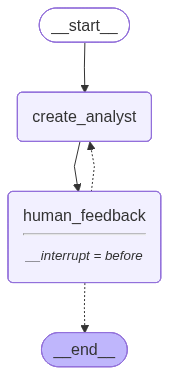

In [161]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [162]:
topic = "the benefits of adopting Langgraph as an agent framework"

In [163]:
max_analysts = 4

In [164]:
thread =  {"configurable":{"thread_id":1}}

In [165]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  
            
        

Name: Alice Chen
Affiliation: Independent AI Lab
Role: AI Research Scientist
Description: Focuses on the technical advantages of Langgraph, such as its ability to manage complex agent interactions and improve the efficiency of multi-agent systems. She is motivated by the potential for Langgraph to advance the state of the art in AI research.
--------------------------------------------------
Name: Bob Johnson
Affiliation: Large Financial Institution
Role: Enterprise Architect
Description: Concerned with the practical benefits of Langgraph for enterprise applications. He evaluates Langgraph based on its scalability, reliability, and ease of integration with existing systems. His primary motive is to reduce development costs and improve the performance of AI-powered services within the institution.
--------------------------------------------------
Name: Charlie Davis
Affiliation: Non-profit AI Ethics Organization
Role: AI Ethics Consultant
Description: Examines the ethical implications 

In [166]:
state = graph.get_state(thread)

In [167]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Alice Chen', role='AI Research Scientist', affiliation='Independent AI Lab', description='Focuses on the technical advantages of Langgraph, such as its ability to manage complex agent interactions and improve the efficiency of multi-agent systems. She is motivated by the potential for Langgraph to advance the state of the art in AI research.'), Analyst(name='Bob Johnson', role='Enterprise Architect', affiliation='Large Financial Institution', description='Concerned with the practical benefits of Langgraph for enterprise applications. He evaluates Langgraph based on its scalability, reliability, and ease of integration with existing systems. His primary motive is to reduce development costs and improve the performance of AI-powered services within the institution.'), Analyst(name='Charlie Davis', role='AI Ethics Consultant', affiliation='Non-profit AI 

In [168]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'analysts': [Analyst(name='Alice Chen', role='AI Research Scientist', affiliation='Independent AI Lab', description='Focuses on the technical advantages of Langgraph, such as its ability to manage complex agent interactions and improve the efficiency of multi-agent systems. She is motivated by the potential for Langgraph to advance the state of the art in AI research.'),
  Analyst(name='Bob Johnson', role='Enterprise Architect', affiliation='Large Financial Institution', description='Concerned with the practical benefits of Langgraph for enterprise applications. He evaluates Langgraph based on its scalability, reliability, and ease of integration with existing systems. His primary motive is to reduce development costs and improve the performance of AI-powered services within the institution.'),
  Analyst(name='Charlie Davis', role='AI Ethics Consultant', affiliation='Non-profit AI Ethics Organiza

In [169]:
state.next

('human_feedback',)

In [ ]:
# memory.storage

In [170]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0a79d4-ff57-6bd4-bfff-5cce46a6887e': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-12T18:57:34.167752+00:00\xa2id\xd9$1f0a79d4-ff57-6bd4-bfff-5cce46a6887e\xb0channel_versions\x81\xa9__start__\xd9400000000000000000000000000000001.0.44792518832204553\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0a79d4-ff5d-6900-8000-1b4b8dbfff42': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-12T18:57:34.170137+00:00\xa2id\xd9$1f0a79d4-ff5d-6900-8000-1b4b8dbfff42\xb0channel_versions\x84\xa9__start__\xd9300000000000000000000000000000002.0.6710847446925291\xa5topic\xd9300000000000000000000000000000002.0.6710847446925291\xacmax_analysts\xd9300000000000000000000000000000002.0.6710847446925291\xb8branch:to:create_analyst\xd9300000000000000000000000000000002.0.6710847446925291\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start__\x

In [ ]:
# import msgpack

# for thread_id, ns_dict in memory.storage.items():
#     print(f"\n Thread ID: {thread_id}")
    
#     # ns_dict = defaultdict(dict, {'': {...}})
#     for ns, ckpts in ns_dict.items():
#         print(f"  Namespace: '{ns}'")
        
#         # ckpts = dict of {checkpoint_id: (packed_values, packed_metadata, parent_id)}
#         for ckpt_id, (packed_values, packed_metadata, parent_id) in ckpts.items():
#             print(f"    Checkpoint ID: {ckpt_id}")
            
#             # Decode msgpack binary
#             values = msgpack.unpackb(packed_values[1], raw=False)
#             meta = msgpack.unpackb(packed_metadata[1], raw=False)
            
#             print(f"    Values keys: {list(values.keys())}")
#             print(f"    Parent ID: {parent_id}")
#             print(f"    Metadata: {meta}")
#             print("-" * 80)


In [171]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a79d5-1ab8-6017-8001-3f99aee53ab6'}}

In [172]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a79e4-2f99-67b3-8002-d7ac4f2d3a5a'}}

In [173]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Alice Chen
Affiliation: Independent AI Lab
Role: AI Research Scientist
Description: Focuses on the technical advantages of Langgraph, such as its ability to manage complex agent interactions and improve the efficiency of multi-agent systems. She is motivated by the potential for Langgraph to advance the state of the art in AI research.
--------------------------------------------------
Name: Bob Johnson
Affiliation: Large Financial Institution
Role: Enterprise Architect
Description: Concerned with the practical benefits of Langgraph for enterprise applications. He evaluates Langgraph based on its scalability, reliability, and ease of integration with existing systems. His primary motive is to reduce development costs and improve the performance of AI-powered services within the institution.
--------------------------------------------------
Name: Charlie Davis
Affiliation: Non-profit AI Ethics Organization
Role: AI Ethics Consultant
Description: Examines the ethical implications 

In [174]:
state = graph.get_state(thread)

In [175]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Ava Chen', role='Startup CTO', affiliation='InnovateAI', description="Focuses on Langgraph's rapid prototyping and deployment capabilities for AI-powered startups. Concerned with minimizing development costs and maximizing speed to market. Motivated by the potential to disrupt traditional industries with innovative AI solutions."), Analyst(name="Liam O'Connell", role='Enterprise AI Architect', affiliation='GlobalTech Solutions', description="Evaluates Langgraph's scalability and integration within large enterprise systems. Concerned with security, compliance, and ensuring seamless interoperability with existing infrastructure. Motivated by driving efficiency and ROI through enterprise-wide AI adoption."), Analyst(name='Dr. Maya Patel'

In [176]:
state.next

('human_feedback',)

In [177]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Ava Chen', role='Startup CTO', affiliation='InnovateAI', description="Focuses on Langgraph's rapid prototyping and deployment capabilities for AI-powered startups. Concerned with minimizing development costs and maximizing speed to market. Motivated by the potential to disrupt traditional industries with innovative AI solutions."),
  Analyst(name="Liam O'Connell", role='Enterprise AI Architect', affiliation='GlobalTech Solutions', description="Evaluates Langgraph's scalability and integration within large enterprise systems. Concerned with security, compliance, and ensuring seamless interoperability with existing infrastructure. Motivated by driving efficiency and ROI through enterprise-wide AI adoption."),
  Analyst(name='Dr. Maya Patel', role='AI Res

In [ ]:
# import msgpack

# def get_all_checkpoints(memory, thread_id="1"):
#     """Return all checkpoints in chronological order for a thread."""
#     checkpoints = []
#     ns_dict = memory.storage.get(thread_id, {})
#     if "" not in ns_dict:
#         return []

#     for ckpt_id, (packed_values, packed_meta, parent_id) in ns_dict[""].items():
#         values = msgpack.unpackb(packed_values[1], raw=False)
#         meta = msgpack.unpackb(packed_meta[1], raw=False)
#         checkpoints.append({
#             "id": ckpt_id,
#             "parent": parent_id,
#             "topic": values.get("topic"),
#             "feedback": values.get("human_analyst_feedback"),
#             "analyst_count": len(values.get("analysts", [])),
#             "analysts": [a.model_dump() for a in values.get("analysts", [])],
#             "step": meta.get("step"),
#             "created_at": values.get("ts", None)
#         })
#     return checkpoints

# # Fetch all
# history = get_all_checkpoints(memory)

# # Sort by step (to get chronological order)
# history = sorted(history, key=lambda x: (x["step"] or 0))

# # Display neatly
# for h in history:
#     print(f"\nSTEP {h['step']} | CHECKPOINT {h['id']}")
#     print(f"Parent: {h['parent']}")
#     print(f"Topic: {h['topic']}")
#     print(f"Feedback: {h['feedback']}")
#     print(f"Analysts generated: {h['analyst_count']}")
#     print("-"*100)


In [178]:
# If we are satisfied, then we simply supply no feedback
further_feedack = ""

In [179]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config

In [180]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a79f0-6718-6a0c-8006-106785895f05'}}

In [181]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)


()


In [182]:
analysts = final_state.values.get('analysts')

In [ ]:
analysts

In [183]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Ava Chen
Affiliation: InnovateAI
Role: Startup CTO
Description: Focuses on Langgraph's rapid prototyping and deployment capabilities for AI-powered startups. Concerned with minimizing development costs and maximizing speed to market. Motivated by the potential to disrupt traditional industries with innovative AI solutions.
--------------------------------------------------
Name: Liam O'Connell
Affiliation: GlobalTech Solutions
Role: Enterprise AI Architect
Description: Evaluates Langgraph's scalability and integration within large enterprise systems. Concerned with security, compliance, and ensuring seamless interoperability with existing infrastructure. Motivated by driving efficiency and ROI through enterprise-wide AI adoption.
--------------------------------------------------
Name: Dr. Maya Patel
Affiliation: AI Research Institute
Role: AI Research Scientist
Description: Interested in Langgraph's novel graph-based approach to agent orchestration and its potential for advancin

In [ ]:
"The benefits of adopting LangGraph as an agent framework"

In [ ]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

Either you can use Google Serper API or use duckduckgo

In [ ]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="The benefits of adopting AWS Cloud").load()
print(docs[0].page_content[:500])

In [ ]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="The benefits of adopting AWS Cloud").load()
print(docs)

In [ ]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="AWS").load()
print(docs[0].page_content[:500])

In [ ]:
from langchain_community.utilities import WikipediaAPIWrapper

In [ ]:
wiki = WikipediaAPIWrapper(doc_content_chars_max=4000)
docs = wiki.run("The benefits of adopting LangGraph as an agentic framework")
print(docs)

## Second Workflow

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [ ]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [ ]:
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

In [ ]:
tavily_search.invoke("langgraph")

In [ ]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 

In [184]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [185]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [189]:
print(analyst.persona)

Name: Carlos Rodriguez
Role: AI Product Manager
Affiliation: DataWise Analytics
Description: Focuses on Langgraph's user-friendliness and its ability to empower citizen data scientists. Concerned with ease of use, accessibility, and the democratization of AI development. Motivated by making AI tools more accessible to a wider audience.



In [186]:
question_instructions.format(goals = analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Carlos Rodriguez\nRole: AI Product Manager\nAffiliation: DataWise Analytics\nDescription: Focuses on Langgraph\'s user-friendliness and its ability to empower citizen data scientists. Concerned with ease of use, accessibility, and the democratization of AI development. Motivated by making AI tools more accessible to a wider audience.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview 

In [ ]:
'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Michael Chen\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"\n\nRemember to stay in character throughout your response, reflecting the persona and goals provided to you.'

In [187]:
def generation_question(state:InterviewState):
    """Node to generate the questions"""
    
    #get state
    analyst = state["analyst"]
    messages = state["messages"]
    
    #generate the question
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    #returen the question through state
    return {"messages":[question]}

In [188]:
analyst

Analyst(name='Carlos Rodriguez', role='AI Product Manager', affiliation='DataWise Analytics', description="Focuses on Langgraph's user-friendliness and its ability to empower citizen data scientists. Concerned with ease of use, accessibility, and the democratization of AI development. Motivated by making AI tools more accessible to a wider audience.")

In [190]:
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

In [191]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[HumanMessage(content="hi do the proper search according to the experties")]}

In [192]:
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name='Carlos Rodriguez', role='AI Product Manager', affiliation='DataWise Analytics', description="Focuses on Langgraph's user-friendliness and its ability to empower citizen data scientists. Concerned with ease of use, accessibility, and the democratization of AI development. Motivated by making AI tools more accessible to a wider audience."),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='hi do the proper search according to the experties', additional_kwargs={}, response_metadata={})]}

In [193]:
result = generation_question(state)

In [194]:
result

{'messages': [AIMessage(content="Okay, here we go.\n\nHi Carlos, my name is Anya Sharma, and I'm an analyst focusing on the practical applications of AI tools for non-technical users. I'm particularly interested in Langgraph and its potential to empower citizen data scientists.\n\nI understand you're an AI Product Manager at DataWise Analytics with a focus on Langgraph's user-friendliness. I'm hoping you can share some insights on how Langgraph is making AI development more accessible.\n\nTo start, what are some of the biggest hurdles you see citizen data scientists facing when trying to build AI-powered applications, and how does Langgraph specifically address those challenges?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--4f27d71d-6786-4961-b7a5-72bfb625f553-0', usage_metadata={'input_tokens': 234, 'output_tokens': 137, 'total_tokens': 

In [195]:
print(result["messages"][0].content)

Okay, here we go.

Hi Carlos, my name is Anya Sharma, and I'm an analyst focusing on the practical applications of AI tools for non-technical users. I'm particularly interested in Langgraph and its potential to empower citizen data scientists.

I understand you're an AI Product Manager at DataWise Analytics with a focus on Langgraph's user-friendliness. I'm hoping you can share some insights on how Langgraph is making AI development more accessible.

To start, what are some of the biggest hurdles you see citizen data scientists facing when trying to build AI-powered applications, and how does Langgraph specifically address those challenges?


In [196]:
from langchain_core.messages import get_buffer_string

In [197]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [199]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [200]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [201]:
result = search_web(state)

In [ ]:
print(result["context"][0])

In [202]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    print("*******************************")
    print(search_query)
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 
    

In [ ]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [ ]:
result = search_wikipedia(state)

In [ ]:
search_docs = WikipediaLoader(query='Langgraph framework benefits',load_all_available_meta=True).load()

In [ ]:
search_docs

In [ ]:
result

In [212]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [208]:
def generate_answer(state:InterviewState):
   
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}
    

how many analyst we were doing to be create:
4

max_trun:2

means if atleast 2 expert are giving ans then we can save the result.

In [206]:
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

In [210]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

In [209]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [211]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}


In [214]:
interview_builder = StateGraph(InterviewState)

In [215]:
interview_builder.add_node("ask_question",generation_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [216]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           route_messages,
                           ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [217]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")


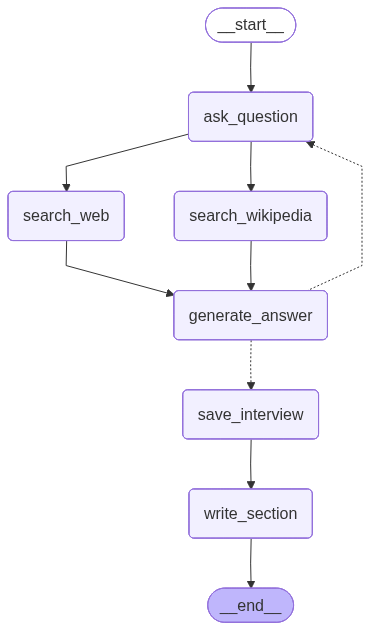

In [218]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [ ]:
analyst

In [ ]:
analyst.persona

In [ ]:
thread = {"configurable": {"thread_id": "1"}}

In [ ]:
from IPython.display import Markdown

In [ ]:
messages = [HumanMessage("So you said you were writing an article on Langchain?")]

In [ ]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

In [ ]:
Markdown(interview['sections'][0])

## third Workflow

In [219]:
from typing_extensions import TypedDict
from typing import List, Annotated
import operator
class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report
    
# class InterviewState(MessagesState):
#     max_num_turns: int # Number turns of conversation
#     context: Annotated[list, operator.add] # Source docs
#     analyst: Analyst # Analyst asking questions
#     interview: str # Interview transcript
#     sections: list # Final key we duplicate in outer state for Send() API

In [220]:
from langgraph.types import Send

In [221]:
def initiate_all_interviews(state:ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """ 
    
    #check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"
    
    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                        "messages": [HumanMessage(
                                            content=f"So you said you were writing an article on {topic}?"
                                        )
                                                ]}) for analyst in state["analysts"]]


In [ ]:
# def write_report(state:ResearchGraphState):
#     """_summary_

#     Args:
#         state (ResearchGraphState): _description_
#     """
#     pass

In [222]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [223]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

In [224]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [225]:
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

In [226]:
def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

In [227]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

In [228]:
# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)


In [229]:
memory = MemorySaver()

In [230]:
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

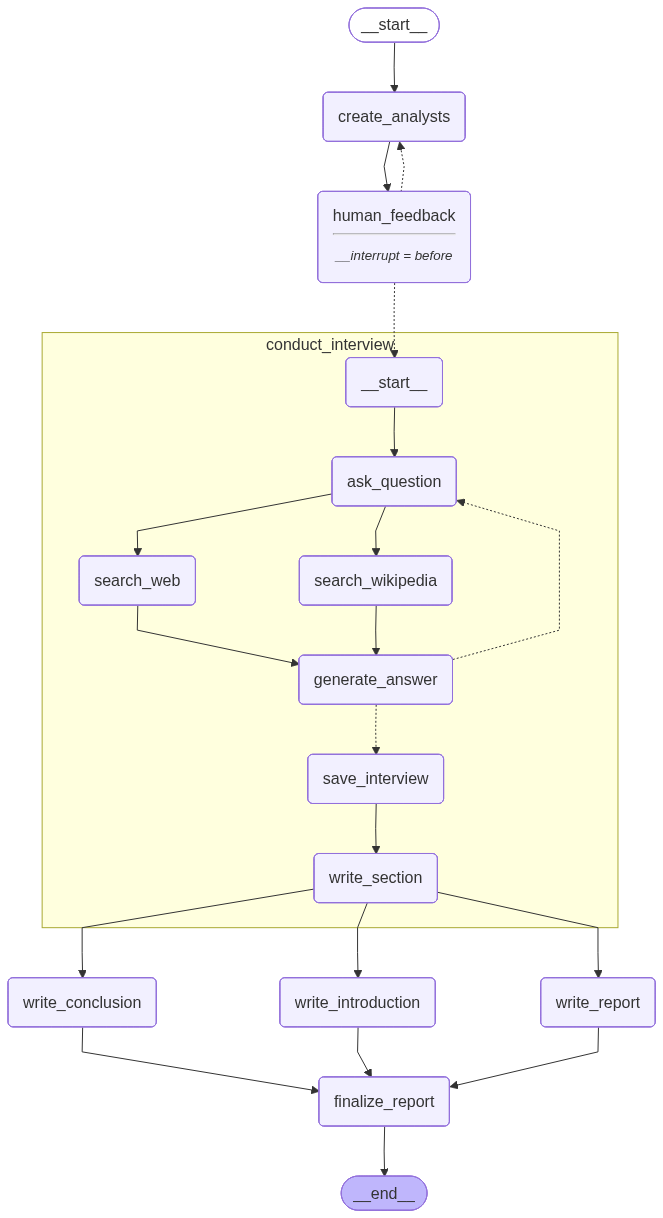

In [231]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [232]:
max_analysts = 3

In [233]:
topic = "How can Mobile phones impact children's education?"

In [ ]:
topic = "How can generative AI accelerate drug discovery?"

In [234]:
thread = {"configurable": {"thread_id": "1"}}

In [235]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Anya Sharma
Affiliation: University Child Development Center
Role: Educational Psychologist
Description: Focuses on the cognitive and emotional impact of mobile phone use on children's learning and development, particularly concerning attention spans and critical thinking skills.
--------------------------------------------------
Name: Mr. Ben Carter
Affiliation: National Education Technology Association
Role: Technology Integration Specialist
Description: Explores the potential of mobile phones as learning tools, advocating for responsible integration into curricula to enhance student engagement and access to educational resources, while addressing equity concerns.
--------------------------------------------------
Name: Ms. Chloe Davis
Affiliation: Parents for Safe Technology
Role: Child Safety Advocate
Description: Prioritizes the safety and well-being of children, emphasizing the risks associated with excessive mobile phone use, including cyberbullying, exposure to inappr

In [ ]:
graph.update_state(thread, {"human_analyst_feedback":"along with the genetive ai in future tell me the future of indian team"}, as_node="human_feedback")

In [ ]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

In [236]:
graph.update_state(thread, {"human_analyst_feedback":""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a85c9-4c83-6816-8002-a1708c91cf1c'}}

In [237]:
graph.get_state(thread).next

('conduct_interview', 'conduct_interview', 'conduct_interview')

In [238]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

*******************************
search_query="overlooked negative impacts of mobile phones on children's education"
*******************************
search_query="impact of mobile phones on children's education beyond distractions"
*******************************
search_query="impact of mobile phones on children's education academic performance student engagement access to resources social-emotional development"
*******************************
search_query='impact of mobile phone use on cognitive development in children'
*******************************
search_query="impact of mobile phone use on children's problem-solving skills and cognitive struggle"
*******************************
search_query="balancing benefits and drawbacks of mobile phones in children's education"
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [239]:
from IPython.display import Markdown

In [240]:
final_state = graph.get_state(thread)


In [241]:
report = final_state.values.get('final_report')

In [242]:
Markdown(report)

# Mobile Phones: A Double-Edged Sword in Children's Education

## Introduction

Mobile phones are ubiquitous, presenting both opportunities and challenges for children's education. This report explores this duality, beginning with an examination of whether smartphones are silencing critical thinking, noting concerns about attention spans and cognitive development. It then pivots to the potential of mobile phones as educational tools, highlighting their capacity to enhance engagement and digital literacy. Finally, the report addresses the critical need for safeguarding children's mental well-being amidst the risks of screen addiction and cyberbullying, advocating for responsible usage and digital literacy. This balanced perspective aims to inform educators, parents, and policymakers on navigating the complex landscape of mobile technology in education.

---



Mobile phones present a complex and multifaceted impact on children's education, characterized by both potential benefits and significant risks. While offering access to vast educational resources and opportunities for enhanced engagement, their presence also raises concerns about cognitive development, mental well-being, and classroom distraction [3, 7, 8].

A key concern revolves around the potential for smartphones to hinder critical thinking and attention spans [1, 5]. The constant connectivity and overstimulation can rewire the adolescent brain, making it difficult for students to concentrate and deeply engage with academic material [1]. Educators are observing a decline in students' ability to focus, with excessive phone use linked to lower test scores and a disruptive learning environment [2, 3]. Early engagement with smartphones may also limit the development of problem-solving skills, as children become overly reliant on phones for quick answers [5]. Some studies suggest that excessive smartphone usage deteriorates cognitive function in children [6].

However, mobile phones also offer educational opportunities, making learning more interactive and accessible [3]. When used correctly, they can broaden students' cognitive horizons and increase engagement [3]. Generation Z's familiarity with digital technology presents an opportunity to integrate mobile devices effectively into education [6, 10].

The mental health implications of mobile phone use are also significant. Excessive use can lead to screen addiction, cyberbullying, and exposure to inappropriate content, negatively impacting children's mental well-being and potentially causing anxiety, depression, and sleep disturbances [1]. Even short periods of mobile phone use can affect cognitive performance, with studies linking prolonged use to impaired cognitive function and poor posture [16].

Addressing these challenges requires a multi-pronged approach involving parents, educators, and policymakers. Clear guidelines on cell phone usage, technology-free zones, and digital literacy programs are essential [2, 9]. Workshops for parents on appropriate social media use can help protect and monitor adolescents [1]. Schools can develop policies that minimize distractions while preparing students for an increasingly digital world [5]. Encouraging open communication, setting boundaries, and establishing appropriate rules can help children navigate the digital world safely [1, 3]. Some states are enacting legislation to reduce cell phone distractions in classrooms and support technology-free zones [5]. Furthermore, parents should be mindful of their own smartphone consumption, as their behavior sets the stage for how children interact with technology [2].

By promoting responsible mobile phone use and digital literacy, we can mitigate the risks and harness the potential of mobile technology to enhance children's education and safeguard their mental well-being.


---

## Conclusion

Mobile phones present a multifaceted challenge to children's education, demanding a balanced approach. While offering potential as educational tools to enhance engagement and access to information, their use can also hinder critical thinking and negatively impact mental well-being. The key lies in responsible integration, clear policies, and digital literacy initiatives. Policymakers, educators, and parents must collaborate to mitigate distractions, promote safe online behavior, and safeguard children's mental health. By addressing these challenges proactively, we can harness the benefits of mobile technology while minimizing its risks, fostering a more conducive and balanced learning environment for future generations.

## Sources

[1] https://www.discovery.org/education/2024/09/06/smartphones-are-killing-kids-ability-to-concentrate/
[2] https://www.slicktext.com/blog/2019/09/survey-smartphones-in-school-statistics/
[3] https://www.edweek.org/teaching-learning/students-dont-think-cellphones-distract-them-from-learning-stem-teachers-disagree/2025/05
[4] https://www.jeremyajorgensen.com/the-impact-of-cellphone-use-on-students-in-the-classroom-negative-effects-resources-and-management-solutions/
[5] https://www.hamilton.k12.wi.us/wp-content/uploads/2024/10/Brain-develpment-and-cell-phones.pdf
[6] https://ijsra.net/sites/default/files/IJSRA-2024-0875.pdf
[7] https://scholarworks.gvsu.edu/cgi/viewcontent.cgi?article=1646&context=gradprojects
[8] https://excelined.org/2024/12/31/scroll-less-learn-more-state-policy-solutions-to-combat-the-impact-of-smartphones-and-social-media-on-education/
[9] https://www.tshanywhere.org/post/impact-mobile-technology-student-attitudes-engagement-learning
[10] https://pmc.ncbi.nlm.nih.gov/articles/PMC9651103/
[11] https://www.panoramaed.com/blog/how-do-cellphones-affect-students-in-school
[12] https://en.wikipedia.org/wiki/Social_media
[13] https://en.wikipedia.org/wiki/Social_media_use_in_education
[14] https://en.wikipedia.org/wiki/Digital_literacy
[15] https://en.wikipedia.org/wiki/Problematic_social_media_use
[16] https://bsd.education/why-mobile-phones-are-a-powerful-learning-tool/
[17] https://compass-uk.org/services/compass-changing-lives/online-resources/what-effects-do-mobile-phones-have-on-children-and-young-peoples-mental-health/
[18] https://www.cune.edu/news/examining-effect-smartphones-child-development
[19] https://pmc.ncbi.nlm.nih.gov/articles/PMC9200624/